# Finetune VGG16

With 1000 x 400 melspectrogra images without data augmentation

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
from PIL import Image

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability

In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings

In [5]:
FINETUNED_MODEL = 'vgg16'

train_csv = '../../data/melspectrogram_train_dataset.csv'
test_csv = '../../data/melspectrogram_test_dataset.csv'
root_dir = '../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images

In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset  

Define the training function

In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    # train mode
    model.train()
    
    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc="training")
    
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed
        
        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })
        
    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100
    
    return model, train_loss, train_accuracy

Define the testing/evaluation function

In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    
    # Switch to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update test loss
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100
    
    return test_loss, test_accuracy

Define what happens in each epoch

In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy =  0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()
        
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        
        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')
    
    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs

In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model

In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning

In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define the learning rate, criterion, optimizer, transformations, and number of epochs

In [14]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning

Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [01:16<00:00,  5.18it/s, Loss=1.278109073638916, Elapsed=86.9685s, ETA=0.0000s]  


Epoch 1 completed in 118.7009s
Train Loss: 1.4204982196228413 - Train Accuracy: 43.66528819327648
Test Loss: 1.2582905990908844 - Test Accuracy: 51.53937475267115

Epoch 2/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.1624152660369873, Elapsed=85.4695s, ETA=0.0000s] 


Epoch 2 completed in 117.3944s
Train Loss: 1.3397628938095478 - Train Accuracy: 46.9953896990443
Test Loss: 1.24413048137318 - Test Accuracy: 51.9192718638702

Epoch 3/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.20it/s, Loss=1.2843620777130127, Elapsed=87.3906s, ETA=0.0000s] 


Epoch 3 completed in 123.3819s
Train Loss: 1.3246271263194989 - Train Accuracy: 47.73343358594353
Test Loss: 1.2070067892170915 - Test Accuracy: 53.13810842896716

Epoch 4/25


training: 100%|██████████| 395/395 [01:26<00:00,  4.55it/s, Loss=1.255051851272583, Elapsed=99.2125s, ETA=0.0000s]   


Epoch 4 completed in 132.2519s
Train Loss: 1.3173336659805683 - Train Accuracy: 48.20831437107976
Test Loss: 1.1965187980671121 - Test Accuracy: 53.1618519984171

Epoch 5/25


training: 100%|██████████| 395/395 [01:17<00:00,  5.13it/s, Loss=1.309837818145752, Elapsed=87.8840s, ETA=0.0000s]  


Epoch 5 completed in 120.9829s
Train Loss: 1.3178053774411165 - Train Accuracy: 47.893705850927006
Test Loss: 1.1771078952635177 - Test Accuracy: 53.91373169766521

Epoch 6/25


training: 100%|██████████| 395/395 [01:17<00:00,  5.13it/s, Loss=1.2179479598999023, Elapsed=87.4725s, ETA=0.0000s] 


Epoch 6 completed in 119.9271s
Train Loss: 1.3178708435613897 - Train Accuracy: 48.05199944597241
Test Loss: 1.1869033936298254 - Test Accuracy: 53.79501385041551

Epoch 7/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.21it/s, Loss=1.247109055519104, Elapsed=86.3975s, ETA=0.0000s]  


Epoch 7 completed in 118.2595s
Train Loss: 1.31192231993132 - Train Accuracy: 48.31911988761155
Test Loss: 1.1681243554510252 - Test Accuracy: 54.31737237831421

Epoch 8/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.26it/s, Loss=1.2965196371078491, Elapsed=86.3388s, ETA=0.0000s] 


Epoch 8 completed in 117.9250s
Train Loss: 1.3076841903638237 - Train Accuracy: 48.70496052553474
Test Loss: 1.171322362591522 - Test Accuracy: 54.81598733676296

Epoch 9/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.2125452756881714, Elapsed=85.1640s, ETA=0.0000s] 


Epoch 9 completed in 117.0706s
Train Loss: 1.3114470143861408 - Train Accuracy: 48.4873068323473
Test Loss: 1.189092259214382 - Test Accuracy: 53.24891175306688

Epoch 10/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.21it/s, Loss=1.4398093223571777, Elapsed=86.2981s, ETA=0.0000s] 


Epoch 10 completed in 118.1965s
Train Loss: 1.3142816815195204 - Train Accuracy: 48.28152515878826
Test Loss: 1.1688688788751158 - Test Accuracy: 55.100910170162244

Epoch 11/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.21it/s, Loss=1.1354340314865112, Elapsed=85.7263s, ETA=0.0000s] 


Epoch 11 completed in 117.7543s
Train Loss: 1.3110462418085411 - Train Accuracy: 48.388373335443916
Test Loss: 1.1761986378467444 - Test Accuracy: 53.71586861891571

Epoch 12/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.2223379611968994, Elapsed=85.4958s, ETA=0.0000s] 


Epoch 12 completed in 117.7830s
Train Loss: 1.310625666908071 - Train Accuracy: 48.50313619185184
Test Loss: 1.1700655324290496 - Test Accuracy: 54.70518401266323

Epoch 13/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.26it/s, Loss=1.1364929676055908, Elapsed=85.8118s, ETA=0.0000s] 


Epoch 13 completed in 117.1815s
Train Loss: 1.3140764652928218 - Train Accuracy: 48.19248501157522
Test Loss: 1.1902485592196685 - Test Accuracy: 53.5180055401662

Epoch 14/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.27it/s, Loss=1.2567218542099, Elapsed=85.4344s, ETA=0.0000s]    


Epoch 14 completed in 116.7002s
Train Loss: 1.3083775251726562 - Train Accuracy: 48.596133678941015
Test Loss: 1.167993921824176 - Test Accuracy: 54.91096161456272

Epoch 15/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.26it/s, Loss=1.5690562725067139, Elapsed=85.5685s, ETA=0.0000s] 


Epoch 15 completed in 117.2162s
Train Loss: 1.3042989954163757 - Train Accuracy: 48.88304081996082
Test Loss: 1.1697834868623753 - Test Accuracy: 54.34111594776415

Epoch 16/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.3091857433319092, Elapsed=85.4817s, ETA=0.0000s] 


Epoch 16 completed in 116.8809s
Train Loss: 1.3084731907784184 - Train Accuracy: 48.564474959931935
Test Loss: 1.1641330171113062 - Test Accuracy: 54.61812425801346

Epoch 17/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.2956798076629639, Elapsed=85.2666s, ETA=0.0000s] 


Epoch 17 completed in 116.5998s
Train Loss: 1.3095370706123641 - Train Accuracy: 48.55656028017966
Test Loss: 1.1617402235666912 - Test Accuracy: 54.76850019786308

Epoch 18/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.26it/s, Loss=1.2205740213394165, Elapsed=85.5179s, ETA=0.0000s] 


Epoch 18 completed in 117.4305s
Train Loss: 1.3084566040884091 - Train Accuracy: 48.52292289123251
Test Loss: 1.1912680105729536 - Test Accuracy: 53.399287692916495

Epoch 19/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.27it/s, Loss=1.2694529294967651, Elapsed=85.5495s, ETA=0.0000s] 


Epoch 19 completed in 116.9286s
Train Loss: 1.304894408093223 - Train Accuracy: 48.66934446664952
Test Loss: 1.1698089476787683 - Test Accuracy: 55.045508508112384

Epoch 20/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.4360495805740356, Elapsed=85.1810s, ETA=0.0000s] 


Epoch 20 completed in 116.4514s
Train Loss: 1.3100881057449534 - Train Accuracy: 48.4873068323473
Test Loss: 1.1917017421337088 - Test Accuracy: 53.11436485951722

Epoch 21/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.29it/s, Loss=1.4327582120895386, Elapsed=85.0290s, ETA=0.0000s] 


Epoch 21 completed in 116.2445s
Train Loss: 1.3044774052463 - Train Accuracy: 48.974059637111935
Test Loss: 1.16495055140871 - Test Accuracy: 54.02453502176494

Epoch 22/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.24it/s, Loss=1.2261184453964233, Elapsed=85.7416s, ETA=0.0000s] 


Epoch 22 completed in 116.9920s
Train Loss: 1.3077623062495944 - Train Accuracy: 48.46554146302855
Test Loss: 1.1663873448516384 - Test Accuracy: 54.05619311436486

Epoch 23/25


training: 100%|██████████| 395/395 [01:14<00:00,  5.28it/s, Loss=1.345710277557373, Elapsed=85.1965s, ETA=0.0000s]  


Epoch 23 completed in 116.7369s
Train Loss: 1.300450681432893 - Train Accuracy: 49.031441065315896
Test Loss: 1.1922106694693517 - Test Accuracy: 52.35457063711911

Epoch 24/25


training: 100%|██████████| 395/395 [01:12<00:00,  5.41it/s, Loss=1.2994602918624878, Elapsed=83.2405s, ETA=0.0000s] 


Epoch 24 completed in 114.6563s
Train Loss: 1.307994992219949 - Train Accuracy: 48.72474722491541
Test Loss: 1.1619840354630442 - Test Accuracy: 54.07202216066482

Epoch 25/25


training: 100%|██████████| 395/395 [01:15<00:00,  5.25it/s, Loss=1.5034313201904297, Elapsed=85.5525s, ETA=0.0000s] 


Epoch 25 completed in 116.8848s
Train Loss: 1.3057456194599972 - Train Accuracy: 48.88304081996082
Test Loss: 1.1644747293356694 - Test Accuracy: 54.35694499406411



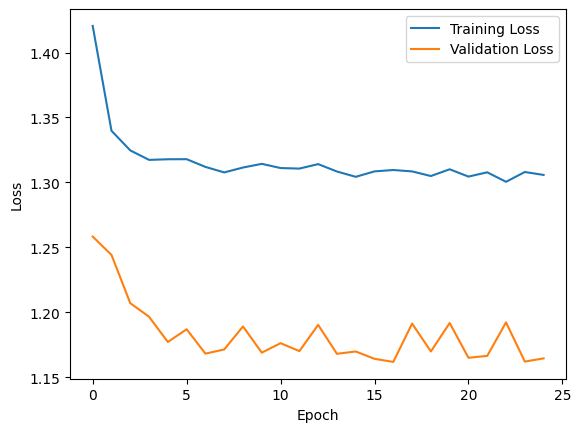

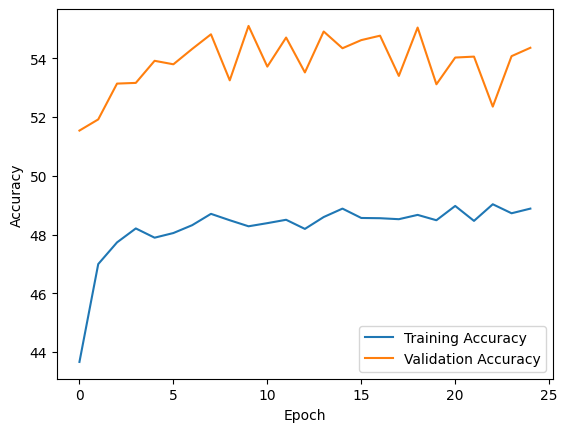

In [15]:
trainset = MelSpectrogramDataset(csv_file=train_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix

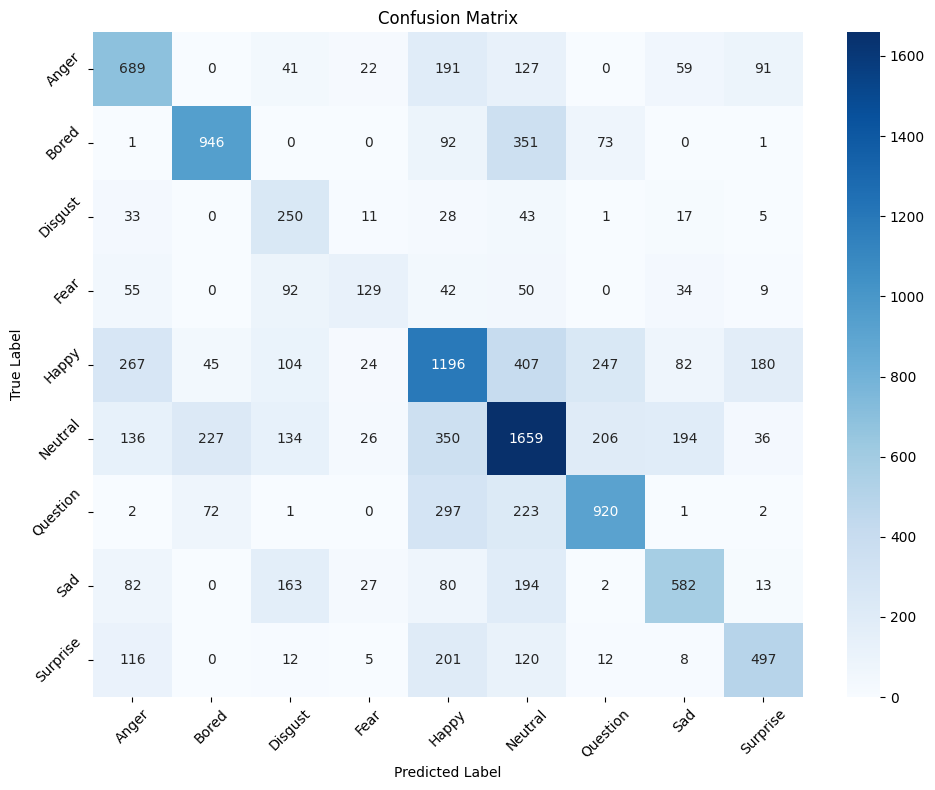

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues', # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())
    
    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    
    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)